In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/CS544 Project/notebooks

/content/drive/Shareddrives/CS544 Project/notebooks


In [ ]:
%%capture
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import math
import torch
import transformers as ppb
import warnings
import re
warnings.filterwarnings('ignore')

In [ ]:
dfs = pd.read_excel("nlp_path_data.xlsx")
#dfs = dfs.rename(columns={'10000194': 'numbers', 'S19-09556': 'code', "Invasive carcinoma of no special type (invasive ductal carcinoma, not otherwise ...": "descriptions"})

In [ ]:
dfs.head()

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140


In [ ]:
np.unique(dfs["Code"])
print(len(np.unique(dfs["Code"])))

117


In [ ]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
        ... 
9043       1
9231       1
8046       1
9680       1
8806       1
Name: Code, Length: 117, dtype: int64

In [ ]:
# Codes we actually want to use:
df_grouped = dfs.groupby(["Code"]).count().reset_index()
codes = df_grouped[df_grouped["Dx"] > 10]["Code"].values
codes

array([8000, 8010, 8020, 8050, 8070, 8071, 8072, 8085, 8120, 8130, 8140,
       8144, 8150, 8170, 8230, 8240, 8250, 8252, 8260, 8310, 8312, 8317,
       8335, 8340, 8380, 8441, 8442, 8461, 8480, 8500, 8510, 8520, 8522,
       8550, 8575, 8720, 8721, 8742, 8743, 8744, 8745, 8802, 8850, 8858,
       8890, 8936, 9061, 9070, 9071])

In [ ]:
dfs = dfs[dfs["Code"].isin(codes)]
dfs

,Dx,Code
0,Adenocarcinoma,8140
1,Adenocarcinoma,8140
2,Adenocarcinoma,8140
3,Adenocarcinoma,8140
4,Adenocarcinoma,8140
...,...,...
6792,Squamous Cell Carcinoma and Variants,8070
6793,"Squamous cell carcinoma, conventional",8070
6794,Ductal carcinoma in situ,8500
6795,Serous carcinoma,8441


In [ ]:
dfs["Code"].value_counts()

8500    1563
8140     827
8550     796
8070     325
8120     294
8312     237
8050     213
8743     204
8441     184
8380     181
8520     174
8000     173
8480     118
8130     115
8720      96
8010      85
8522      71
8936      70
8260      66
8150      58
8721      47
8240      47
8071      46
8744      44
8340      38
8850      34
8742      31
8170      27
8745      26
8072      25
8317      24
8461      20
8230      19
9061      19
8802      18
8575      17
8858      16
8250      15
8020      15
8252      15
8890      14
8442      14
9070      13
8085      13
8335      13
8310      13
8510      12
9071      12
8144      11
Name: Code, dtype: int64

# Preprocessing:

In [ ]:
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
dfs["Dx"] = dfs["Dx"].str.lower()
dfs["Dx"] = dfs["Dx"].replace(r'[^a-z|\s]', '', regex=True)
dfs["Dx"] = dfs["Dx"].replace(r'\s\s+', ' ', regex=True)


# BERT Embedding

In [ ]:
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dfs

,Dx,Code
0,adenocarcinoma,8140
1,adenocarcinoma,8140
2,adenocarcinoma,8140
3,adenocarcinoma,8140
4,adenocarcinoma,8140
...,...,...
6792,squamous cell carcinoma and variants,8070
6793,squamous cell carcinoma conventional,8070
6794,ductal carcinoma in situ,8500
6795,serous carcinoma,8441


In [ ]:
#icd_codes = dfs["preprocessed_ICD_codes"]
icd_codes_d = {}
for i, code in sorted(enumerate(set(dfs["Code"]))):
  icd_codes_d[code] = i
icd_codes_d

{8000: 25,
 8010: 29,
 8020: 33,
 8050: 42,
 8070: 0,
 8071: 1,
 8072: 2,
 8085: 9,
 8120: 19,
 8130: 26,
 8140: 31,
 8144: 32,
 8150: 34,
 8170: 39,
 8230: 16,
 8240: 17,
 8250: 21,
 8252: 23,
 8260: 27,
 8310: 43,
 8312: 44,
 8317: 47,
 8335: 4,
 8340: 8,
 8380: 22,
 8441: 45,
 8442: 46,
 8461: 3,
 8480: 11,
 8500: 18,
 8510: 24,
 8520: 28,
 8522: 30,
 8550: 37,
 8575: 48,
 8720: 5,
 8721: 6,
 8742: 12,
 8743: 13,
 8744: 14,
 8745: 15,
 8802: 35,
 8850: 7,
 8858: 10,
 8890: 20,
 8936: 38,
 9061: 36,
 9070: 40,
 9071: 41}

In [ ]:
dfs['Code_n'] = dfs['Code'].apply(lambda x: icd_codes_d[x])
dfs['Code_n']

0       31
1       31
2       31
3       31
4       31
        ..
6792     0
6793     0
6794    18
6795    45
6796    37
Name: Code_n, Length: 6508, dtype: int64

In [ ]:
dfs

,Dx,Code,Code_n
0,adenocarcinoma,8140,31
1,adenocarcinoma,8140,31
2,adenocarcinoma,8140,31
3,adenocarcinoma,8140,31
4,adenocarcinoma,8140,31
...,...,...,...
6792,squamous cell carcinoma and variants,8070,0
6793,squamous cell carcinoma conventional,8070,0
6794,ductal carcinoma in situ,8500,18
6795,serous carcinoma,8441,45


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dfs, test_size=0.2)

In [ ]:
train = train.reset_index(drop = True)
train

,Dx,Code,Code_n
0,ductal carcinoma in situ classified as tis dci...,8500,18
1,adenocarcinoma intestinal type,8144,32
2,ductal carcinoma in situ,8500,18
3,urothelial carcinoma in situ,8120,19
4,acinar adenocarcinoma,8550,37
...,...,...,...
5201,acinar adenocarcinoma,8550,37
5202,papillary carcinoma other variant specify,8260,27
5203,invasive carcinoma of no special type invasive...,8500,18
5204,lentigo maligna melanoma,8742,12


In [ ]:
test = test.reset_index(drop = True)
test

,Dx,Code,Code_n
0,invasive squamous cell carcinoma nonkeratinizing,8072,2
1,acinar adenocarcinoma,8550,37
2,acinar adenocarcinoma,8550,37
3,superficial spreading melanoma,8743,13
4,ductal carcinoma in situ,8500,18
...,...,...,...
1297,ductal carcinoma in situ,8500,18
1298,invasive carcinoma with ductal and lobular fea...,8522,30
1299,papillary carcinoma classic usual conventional,8050,42
1300,invasive carcinoma of no special type ductal n...,8500,18


In [ ]:
#pad everything to the same size! Set to the length of the largest input
tokenized = test["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized[0])
# Set manually 
max_len = 34

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask[0])
test_attention_mask = attention_mask
input_ids = torch.tensor(padded)
index = 1
print(input_ids[index])
print(test["Dx"][index])

[101, 17503, 5490, 6692, 27711, 3526, 2482, 21081, 2863, 2512, 5484, 20363, 6026, 102]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tensor([  101,  9353,  3981,  2099, 16298, 24755, 11890,  5740,  2863,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
acinar adenocarcinoma


In [ ]:
x_test = input_ids
attention_mask_test = attention_mask
y_test = test['Code_n'].values
x_test.shape, y_test.shape

(torch.Size([1302, 34]), (1302,))

In [ ]:
test_data = []
for i in range(len(x_test)):
    test_data.append([attention_mask_test[i], x_test[i], y_test[i]])

In [ ]:
dfs = train

## Upsampling

In [ ]:
dfs['Code'].value_counts()

8500    1256
8140     664
8550     626
8070     263
8120     236
8312     187
8050     168
8743     162
8380     151
8441     148
8520     141
8000     137
8480      95
8130      92
8720      81
8010      67
8936      55
8522      55
8260      48
8150      45
8721      39
8071      38
8240      37
8744      36
8340      29
8850      28
8742      25
8745      22
8170      21
8072      20
9061      18
8317      17
8461      15
8230      15
8250      15
8802      14
8335      13
8252      12
8575      12
8020      12
9070      11
8085      11
8858      11
8442      10
8310      10
8510      10
9071      10
8890       9
8144       9
Name: Code, dtype: int64

In [ ]:
### Upsample for Class balance:
from sklearn.utils import resample

df_majority = dfs[dfs.loc[:,"Code"]==8500]
max_len = len(df_majority)
for code in codes:
  if code != 8500:
    df_minority = dfs[dfs.loc[:,"Code"]==code]
    upsampled_minority = resample(df_minority, replace=True, n_samples=max_len)
    df_majority = pd.concat([df_majority, upsampled_minority])

df_majority

,Dx,Code,Code_n
0,ductal carcinoma in situ classified as tis dci...,8500,18
2,ductal carcinoma in situ,8500,18
5,invasive carcinoma of no special type ductal,8500,18
15,invasive carcinoma of no special type ductal n...,8500,18
19,ductal adenocarcinoma,8500,18
...,...,...,...
4620,somatically derived yolk sac tumor,9071,41
4620,somatically derived yolk sac tumor,9071,41
3015,yolk sac tumor postpubertal type specify perce...,9071,41
2134,yolk sac tumor postpubertal type specify perce...,9071,41


In [ ]:
#Proof of upsample working:
df_majority["Code"].value_counts()[1:10]

8522    1256
8936    1256
8744    1256
8520    1256
8072    1256
9071    1256
8335    1256
9070    1256
8170    1256
Name: Code, dtype: int64

In [ ]:
### How many Codes do we want??? 1) 117 2) grouped version

In [ ]:
df_upsampled = df_majority.copy()

In [ ]:
'''
#remove non-alphabetical characters, lower case, puctuation, extra spaces. 
df_upsampled["Dx"] = df_upsampled["Dx"].str.lower()
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'[^a-z|\s]', '', regex=True)
df_upsampled["Dx"] = df_upsampled["Dx"].replace(r'\s\s+', ' ', regex=True)
'''

'\n#remove non-alphabetical characters, lower case, puctuation, extra spaces. \ndf_upsampled["Dx"] = df_upsampled["Dx"].str.lower()\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'[^a-z|\\s]\', \'\', regex=True)\ndf_upsampled["Dx"] = df_upsampled["Dx"].replace(r\'\\s\\s+\', \' \', regex=True)\n'

In [ ]:
df_upsampled["Dx"]

0       ductal carcinoma in situ classified as tis dci...
2                                ductal carcinoma in situ
5            invasive carcinoma of no special type ductal
15      invasive carcinoma of no special type ductal n...
19                                  ductal adenocarcinoma
                              ...                        
4620                   somatically derived yolk sac tumor
4620                   somatically derived yolk sac tumor
3015    yolk sac tumor postpubertal type specify perce...
2134    yolk sac tumor postpubertal type specify perce...
3088                                       yolk sac tumor
Name: Dx, Length: 61544, dtype: object

In [ ]:
df_upsampled.head()

,Dx,Code,Code_n
0,ductal carcinoma in situ classified as tis dci...,8500,18
2,ductal carcinoma in situ,8500,18
5,invasive carcinoma of no special type ductal,8500,18
15,invasive carcinoma of no special type ductal n...,8500,18
19,ductal adenocarcinoma,8500,18


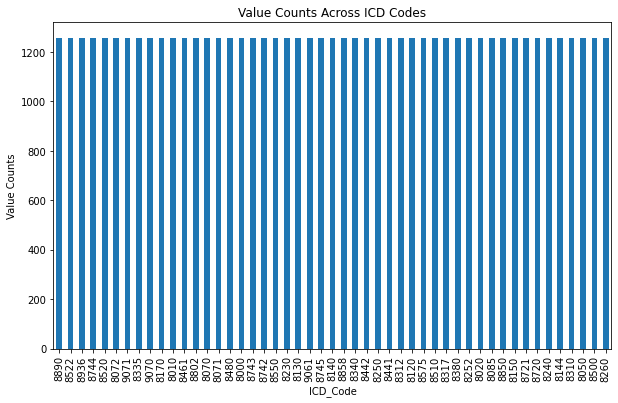

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
df_upsampled['Code'].value_counts().plot(ax=ax, kind='bar')
ax.set_xlabel("ICD_Code")
ax.set_ylabel("Value Counts")
ax.set_title("Value Counts Across ICD Codes");

In [ ]:
'''
#Load the pretrained bert model
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
'''

"\n#Load the pretrained bert model\nmodel_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')\n\n# Load pretrained model/tokenizer\ntokenizer = tokenizer_class.from_pretrained(pretrained_weights)\nmodel = model_class.from_pretrained(pretrained_weights)\n"

In [ ]:
from transformers import AutoModel
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#df_upsampled.iloc[1392]

In [ ]:
tokenized = df_upsampled["Dx"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
tokenized.iloc[1392]

[101,
 2482,
 21081,
 10286,
 9006,
 2050,
 16007,
 27881,
 3816,
 19875,
 3917,
 2937,
 13656,
 102]

In [ ]:
#pad everything to the same size! Set to the length of the largest input
max_len = 34
'''
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
'''
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
#implement the attention mask
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(61544, 34)

In [ ]:
input_ids = torch.tensor(padded)

In [ ]:
#input_ids is the embedding of the sentence
print(len(input_ids))
print(len(df_upsampled))

61544
61544


In [ ]:
index = 1
print(input_ids[index])
print(df_upsampled["Dx"][index])

tensor([  101, 23245,  2389,  2482, 21081,  2863,  1999, 26179,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
                  ...              
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
1    adenocarcinoma intestinal type
Name: Dx, Length: 127, dtype: object


In [ ]:
### Have to encode 0-9 each of the ICD Codes: 

In [ ]:
#vectorize the Y keys to corresponding values:
y_train = df_upsampled["Code"].values
y_train = np.vectorize(icd_codes_d.get)(y_train)
y_train

array([18, 18, 18, ..., 41, 41, 41])

In [ ]:
# train, dev, test: 

In [ ]:
# train-test split:
test_size = int(np.floor(len(y_train)*.25))
rand_test_ints = np.random.randint(low=0, high=len(y_train), size=test_size)

y_dev = y_train[rand_test_ints]
y_train = np.delete(y_train, rand_test_ints, axis=0)

x_dev = input_ids[rand_test_ints]
x_train = np.delete(input_ids, rand_test_ints, axis=0)

attention_mask_dev = attention_mask[rand_test_ints]
attention_mask_train = np.delete(attention_mask, rand_test_ints, axis = 0)

In [ ]:
x_train

tensor([[  101, 23245,  2389,  ...,     0,     0,     0],
        [  101, 17503,  2482,  ...,     0,     0,     0],
        [  101, 23245,  2389,  ...,     0,     0,     0],
        ...,
        [  101, 10930, 13687,  ...,     0,     0,     0],
        [  101, 10930, 13687,  ...,     0,     0,     0],
        [  101, 10930, 13687,  ...,     0,     0,     0]])

In [ ]:
y_train.shape, y_dev.shape, attention_mask_dev.shape, attention_mask_test.shape, attention_mask_train.shape

((47963,), (15386,), (15386, 34), (1302, 34), (47963, 34))

In [ ]:
#Format X, Y for input into NN: (For Dataloader)
train_data = []
for i in range(len(x_train)):
    train_data.append([attention_mask_train[i],x_train[i], y_train[i]])
    
dev_data = []
for i in range(len(x_dev)):
    dev_data.append([attention_mask_dev[i],x_dev[i], y_dev[i]])

In [ ]:
y_train = torch.tensor(y_train)
y_dev = torch.tensor(y_dev)

In [ ]:
x_dev.shape

torch.Size([15386, 34])

# Classifying

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn

In [ ]:
attention_mask_train = torch.tensor(attention_mask_train)
attention_mask_dev = torch.tensor(attention_mask_dev)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(x_train, attention_mask_train, y_train)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(x_dev, attention_mask_dev, y_dev)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
test_data = TensorDataset(x_test, attention_mask_test, y_test)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)


In [ ]:
y_test = torch.tensor(y_test)
attention_mask_test = torch.tensor(attention_mask_test)
test_data = TensorDataset(x_test, attention_mask_test, y_test)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)


In [ ]:
# Try once without these:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,49)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
model_t = BERT_Arch(bert)

# push the model to GPU
model = model_t.to(device)

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)  

In [ ]:
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 10

In [ ]:
def train():
  
  model_t.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(50):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  1,499.
  Batch   100  of  1,499.
  Batch   150  of  1,499.
  Batch   200  of  1,499.
  Batch   250  of  1,499.
  Batch   300  of  1,499.
  Batch   350  of  1,499.
  Batch   400  of  1,499.
  Batch   450  of  1,499.
  Batch   500  of  1,499.
  Batch   550  of  1,499.
  Batch   600  of  1,499.
  Batch   650  of  1,499.
  Batch   700  of  1,499.
  Batch   750  of  1,499.
  Batch   800  of  1,499.
  Batch   850  of  1,499.
  Batch   900  of  1,499.
  Batch   950  of  1,499.
  Batch 1,000  of  1,499.
  Batch 1,050  of  1,499.
  Batch 1,100  of  1,499.
  Batch 1,150  of  1,499.
  Batch 1,200  of  1,499.
  Batch 1,250  of  1,499.
  Batch 1,300  of  1,499.
  Batch 1,350  of  1,499.
  Batch 1,400  of  1,499.
  Batch 1,450  of  1,499.

Evaluating...
  Batch    50  of    481.
  Batch   100  of    481.
  Batch   150  of    481.
  Batch   200  of    481.
  Batch   250  of    481.
  Batch   300  of    481.
  Batch   350  of    481.
  Batch   400  of    481.
  Batch 

KeyboardInterrupt: ignored

In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(x_test.to(device), attention_mask_test.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69        62
           1       0.67      0.75      0.71         8
           2       0.33      0.60      0.43         5
           3       0.56      1.00      0.71         5
           4       0.00      0.00      0.00         0
           5       0.68      0.87      0.76        15
           6       0.25      0.62      0.36         8
           7       0.80      0.67      0.73         6
           8       0.62      0.89      0.73         9
           9       0.50      1.00      0.67         2
          10       1.00      1.00      1.00         5
          11       0.57      0.35      0.43        23
          12       0.62      0.83      0.71         6
          13       0.87      0.81      0.84        42
          14       0.21      0.75      0.32         8
          15       0.50      1.00      0.67         4
          16       0.27      0.75      0.40         4
          17       0.64    